In [117]:
#импортируем библиотеки

import requests
import json
import time
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#создаем функцию для получения данных со страницы поиска hh c заданными парметрами
#в имени вакансии есть слово "аналитик", г. Екатеринбург, 100 вакансий на странице

def get_page(page=0):
    param = {'text':'NAME:Аналитик', 'area':3, 'page': page, 'per_page':100}
    r = requests.get('https://api.hh.ru/vacancies/', params=param)
    return r.text

In [114]:
#считываем первые 2000 вакансий

for page in range(20):
    vac_page = json.loads(get_page(page))
#если вакансий меньше, чем 2000-остановить цикл 
    if vac_page['pages'] - page <= 1: 
        break
#записываем даннные со страницы поиска hh в файл
    file_name = 'analytics_vacancies_page_{}.json'
    file_name = file_name.format(page+1)
    with open(file_name, 'a', encoding='utf-8') as file:
        file.write(json.dumps(vac_page, ensure_ascii=False))

In [115]:
#достаем url-адрес вакансии из файла поисковой выдачи, на каждой странице
#обращаемся к API по ссылке и получаем детальную информацию по каждой вакансии
#записываем данные вакансии в файл

for file in os.listdir('C:\\Users\\osinc\\hh_vacs\\vacs_pages'):
    with open('C:\\Users\\osinc\\hh_vacs\\vacs_pages\\{}'.format(file), 'r', encoding='utf-8') as page:
        page_read = page.read()
    pages_json = json.loads(page_read)
    for vac in pages_json['items']:
        r = requests.get(vac['url'])
        if r.status_code == 200:
            file_name = 'analytics_vacancies_{}.json'
            file_name = file_name.format(vac['id'])
            with open(file_name, 'a', encoding='utf-8') as file:
                file.write(json.dumps(json.loads(r.text), ensure_ascii=False))
    time.sleep(0.25)

In [75]:
#вытаскиваем данные вакансии в список

ID = [] #id вакансии
names = [] #имя вакансии
descriptions = [] #описание вакансии
salary = []
skills_vac = [] #id вакансии
skills_name = [] #требуемые скилы вакансии
for file in os.listdir('C:\\Users\\osinc\\hh_vacs\\all_vacs'):
    with open('C:\\Users\\osinc\\hh_vacs\\all_vacs\\{}'.format(file), 'r', encoding='utf-8') as vacs:
        vacs_read = vacs.read()
    vacs_json = json.loads(vacs_read)
    ID.append(vacs_json['id'])
    names.append(vacs_json['name'])
    salary.append(vacs_json['salary'])
    descriptions.append(vacs_json['description'])
    for skill in vacs_json['key_skills']:
        skills_vac.append(vacs_json['id'])
        skills_name.append(skill['name'])

In [108]:
#очищаем описание вакансии от html тегов
descriptions = list(map(lambda x:re.sub(r"<[^>]+>", "",x, flags=re.S), descriptions))

In [101]:
# приводим данные о зарплате в нужный нам вид
def salary_return(salary):
    if salary is not None:
        if salary['from'] is None:
            return salary['to']
        else:
            return salary['from']
    else:
        return 'Не указана'
salary = list(map(salary_return,salary))

In [110]:
#создаем датафрейм с вакансиями

vacancies = pd.DataFrame({'vacancie_id': ID, 'name': names, 'salary': salary , 'description': descriptions})

In [158]:
#создаем датафрейм со скилами вакансии

skills = pd.DataFrame({'vacancie_id': skills_vac, 'skill': skills_name})

In [169]:
# cохраним файл с описанием вакасий в сsv
vacancies.to_csv('vacancies.csv',index=False)

In [112]:
vacancies.head()

,vacancie_id,name,salary,description
0,52410283,Аналитик 1С в департамент корпоративных проектов,Не указана,Диалог ИТ – ведущий системный интегратор в обл...
1,76857371,Экономист аналитик (жд транспорт),60000,Работа в УГПХ - это работа в крупной развивающ...
2,77195491,Аналитик 1C:ЗУП,Не указана,Мы – команда службы поддержки 1С. Мы работаем ...
3,78253081,Аналитик баз данных,50250,Обязанности: - Выгрузка массивов данных из 1...
4,79192941,Маркетолог-аналитик данных фармотрасли,80000,Уралбиофарм - одно из крупнейших фармацевтичес...


In [116]:
skills.head()

,vacancie_id,skill
0,77195491,1С: Зарплата и управление персоналом
1,77195491,Разработка технических заданий
2,77195491,Постановка задач разработчикам
3,77195491,Разработка инструкций
4,77195491,MS Visio


In [130]:
#распределение зарплат
vacancies_salary = vacancies.salary.value_counts().reset_index().rename(columns={'index':'salary', 'salary':'count'})

In [149]:
#выводим данные о зарплатах

min_salary = vacancies_salary.query('salary != "Не указана"').salary.min()
max_salary = vacancies_salary.query('salary != "Не указана"').salary.max()
median_salary = vacancies_salary.query('salary != "Не указана"').salary.median()
print(f'Минимальная зарплата {min_salary} \nМаксимальная зарплата {max_salary} \nМедианная зарплата {median_salary}')

Минимальная зарплата 30000 
Максимальная зарплата 250000 
Медианная зарплата 76080.0


<Axes: xlabel='salary', ylabel='count'>

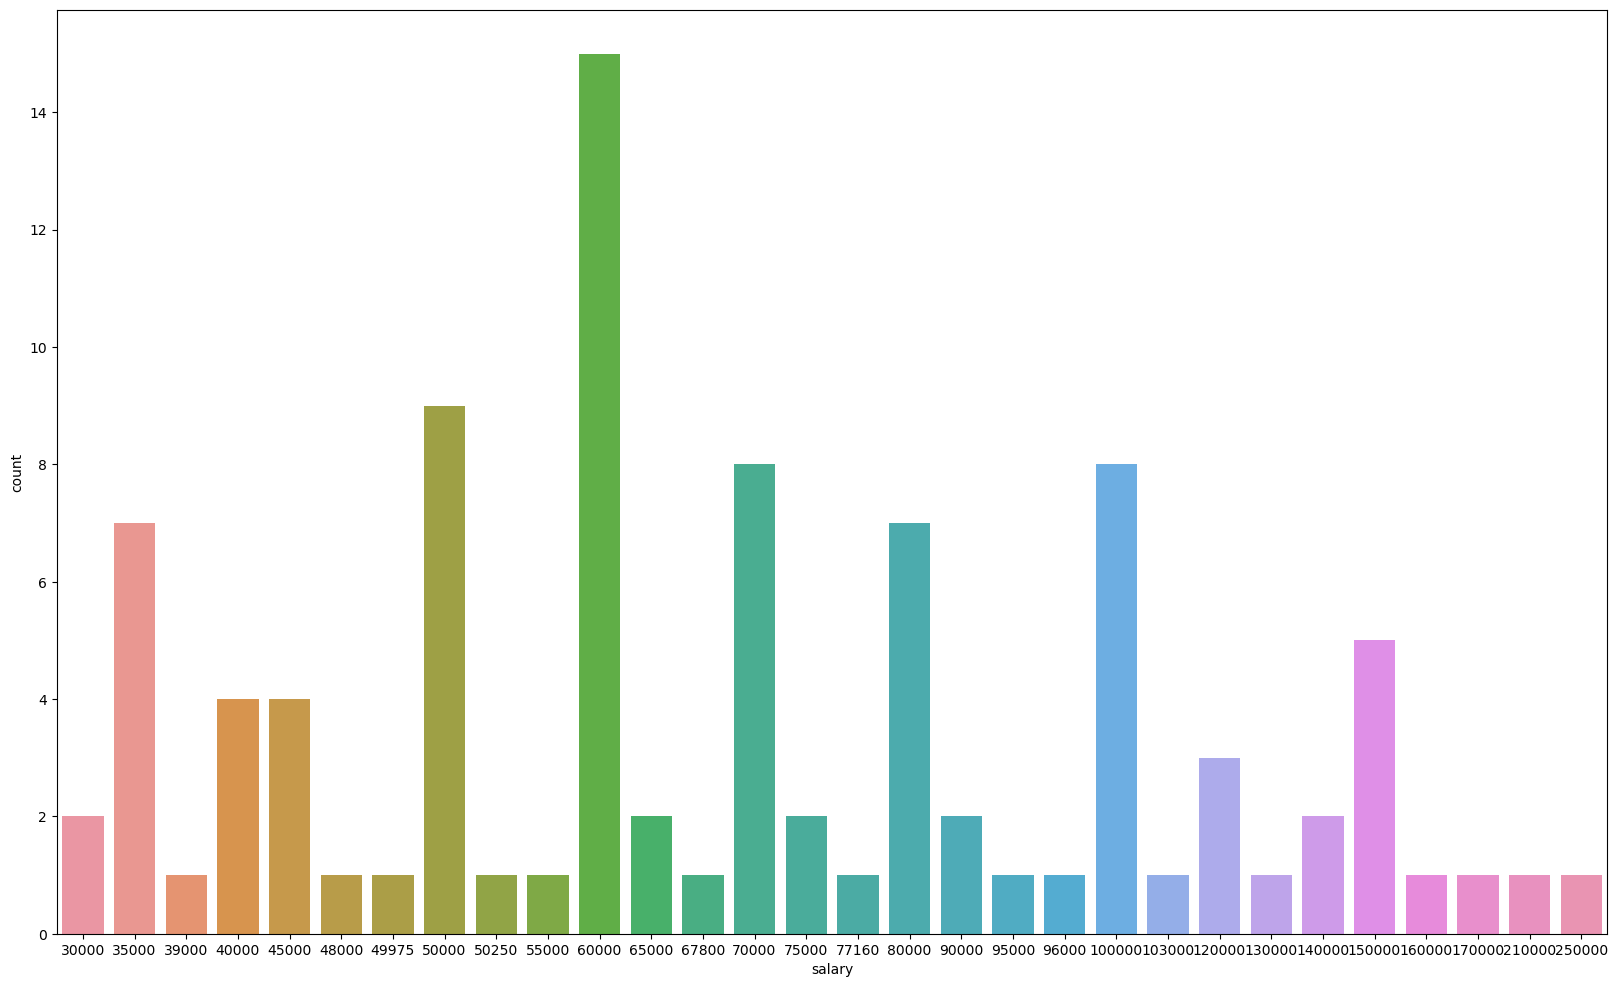

In [156]:
#построим график распределения зарплат на кол-во вакансий

plt.figure(figsize=(20, 12))
sns.barplot(vacancies_salary.query('salary != "Не указана"'), x='salary', y='count')

In [165]:
#сформируем топ-15 необходимых навыков

top_15_skills = skills.skill.value_counts().head(15).reset_index().rename(columns={'index':'skill', 'skill':'count'})

<Axes: xlabel='count', ylabel='skill'>

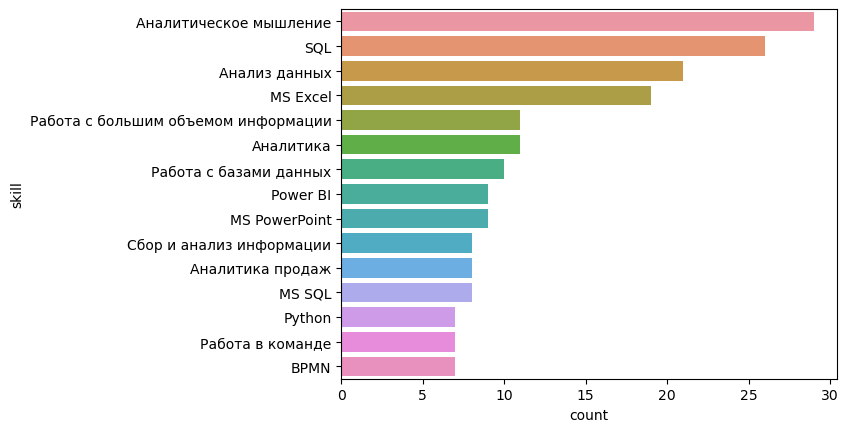

In [167]:
#топ-15 необходимых навыков

sns.barplot(top_15_skills, x='count',y='skill')